In [1]:
import matplotlib.pyplot as plt
import numpy as np
import corner

In [2]:
def linear_model(x, m, c):
    return m*x + c

### Generate data with Gaussian noise

\begin{align}
y = f(x) + n
\end{align}

Fetch some $\{y_i, x_i\}$. $n$ is a Gaussian.

In [3]:
injection_parameters = dict(m=0.8, c=2)

In [4]:
num_points = 100
x = np.linspace(-4, 4, num_points)

In [5]:
sigma = 0.6

In [6]:
data = linear_model(x, **injection_parameters) + np.random.normal(0, sigma, x.size)

Text(0, 0.5, 'y')

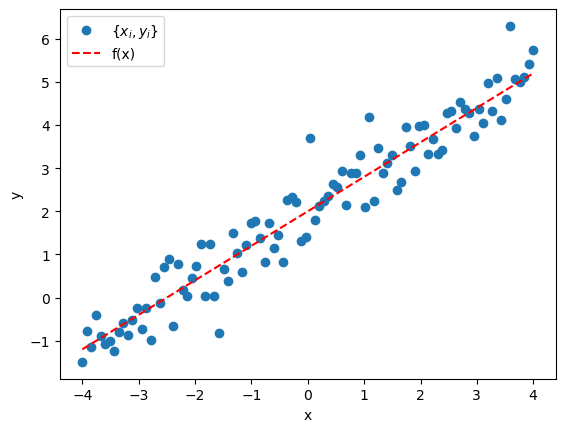

In [7]:
fig, ax = plt.subplots()
ax.plot(x, data, 'o', label='$\\{x_i, y_i\\}$')
ax.plot(x, linear_model(x, **injection_parameters), '--r', label='f(x)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

In [8]:
import bilby
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform, DeltaFunction

In [9]:
priors = dict()

priors['m'] = Uniform(-3, 3, name='m', latex_label='m')
priors['c'] = Uniform(-3, 3, name='c', latex_label='c')

In [10]:
log_l = GaussianLikelihood(x, data, linear_model, sigma=sigma)

In [11]:
result = bilby.run_sampler(
    likelihood=log_l, priors=priors, sampler='dynesty',
    nlive=300, npool=4, save=False, clean=True,
    injection_parameters=injection_parameters,
    outdir='./linear_regression', 
    label='linear_regression')

12:28 bilby INFO    : Running for label 'linear_regression', output will be saved to './linear_regression'
12:28 bilby INFO    : Analysis priors:
12:28 bilby INFO    : m=Uniform(minimum=-3, maximum=3, name='m', latex_label='m', unit=None, boundary=None)
12:28 bilby INFO    : c=Uniform(minimum=-3, maximum=3, name='c', latex_label='c', unit=None, boundary=None)
12:28 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
12:28 bilby INFO    : Analysis likelihood noise evidence: nan
12:28 bilby INFO    : Single likelihood evaluation took nan s
12:28 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 300, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 4, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'gradient': None, 'grad_args': None

1it [00:00, ?it/s]

12:28 bilby INFO    : Written checkpoint file ./linear_regression/linear_regression_resume.pickle
12:28 bilby INFO    : Written checkpoint file ./linear_regression/linear_regression_resume.pickle
12:28 bilby INFO    : Starting to close worker pool.
12:28 bilby INFO    : Finished closing worker pool.
12:28 bilby INFO    : Rejection sampling nested samples to obtain 767 posterior samples
12:28 bilby INFO    : Sampling time: 0:00:11.426011
12:28 bilby INFO    : Summary of results:
nsamples: 767
ln_noise_evidence:    nan
ln_evidence: -85.352 +/-  0.190
ln_bayes_factor:    nan +/-  0.190



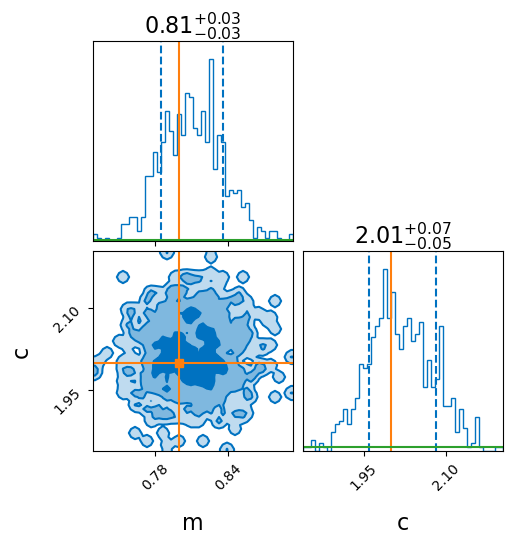

In [12]:
result.plot_corner(priors=True, quantiles=(0.16, 0.84))

In [13]:
print("Expected width of m = {:.2f}".format(sigma/np.sqrt(np.sum((x)**2))))

Expected width of m = 0.03


In [14]:
print("Expected width of c = {:.2f}".format(sigma * np.sqrt(1/num_points)))

Expected width of c = 0.06


# Same problem by training a normalizing flow

In [15]:
from IPython.display import clear_output
from time import sleep

def live_plot_samples(samples, truth):
    clear_output(wait=True)
    sleep(1)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.16, 0.5, 0.84],
        show_titles=True, labels=["m", "c"],
        truth=truth
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")


def live_plot_bilby_result(result, **kwargs):
    clear_output(wait=True)
    sleep(1)
    result.plot_corner(priors=True)

In [16]:
def get_data(m=None, c=None, num_points=1):
    """Sample m, c and return a batch of data with noise"""
    m = priors['m'].sample() if m is None else m
    c = priors['c'].sample() if c is None else c
    x = np.linspace(-4, 4, num_points)
    y = m*x + c
    y += sigma*np.random.normal(size=x.size)

    return x, y, m, c

# Generate simulations

In [17]:
from torch.utils.data import Dataset, DataLoader

In [18]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

In [19]:
import pytorch_lightning as pl

In [20]:
num_simulations = 20000
theta_vals = []
data_vals = []
for ii in range(num_simulations):
    x_val, y_val, m_val, c_val = get_data(num_points=100)
    data_vals.append(y_val)
    theta_vals.append([m_val, c_val])

In [21]:
theta_vals = torch.from_numpy(np.array(theta_vals)).to(torch.float32)
data_vals = torch.from_numpy(np.array(data_vals)).to(torch.float32)

In [22]:
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return theta_vals[idx], data_vals[idx]

In [23]:
dataset = DataGenerator()

In [24]:
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

In [25]:
TRAIN_BATCH_SIZE = 40
TEST_BATCH_SIZE = 1
LR = 1e-3

In [26]:
import torch.distributions as dist

In [27]:
from pyro.nn import ConditionalAutoRegressiveNN
from pyro.distributions import ConditionalTransformedDistribution
from pyro.distributions.transforms import ConditionalAffineAutoregressive

# MADE in Pytorch Lightning

In [28]:
import pandas as pd

def cast_as_bilby_result(samples, truth):
    injections = dict.fromkeys(injection_parameters)
    injections['m'] = float(truth.numpy()[0])
    injections['c'] = float(truth.numpy()[1])

    posterior = dict.fromkeys(injection_parameters)
    samples_numpy = samples.numpy()
    posterior['m'] = samples_numpy.T[0].flatten()
    posterior['c'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)
    
    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=list(injections.keys()),
        priors=priors
    )

In [29]:
class MADE(pl.LightningModule):
    def __init__(
        self,
        input_dim,
        context_dim,
        hidden_dim,
        learning_rate: float = LR,
        batch_size: int = TRAIN_BATCH_SIZE,
    ):
        super().__init__()
        self.base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
        self.hypernet = ConditionalAutoRegressiveNN(input_dim, context_dim, hidden_dim)
        self.transform = ConditionalAffineAutoregressive(self.hypernet)
        self.flow = ConditionalTransformedDistribution(self.base_dist, [self.transform])

        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def log_prob(self, theta, data):
        return self.flow.condition(data).log_prob(theta).mean()

    
    def training_step(self, batch, batch_idx):
        theta, data = batch
        loss = - self.log_prob(theta, data)
        self.log("train_loss", loss, on_step=True, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        theta, data = batch
        loss = - self.log_prob(theta, data)
        self.log("valid_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        theta, data = batch
        loss = - self.log_prob(theta, data)
        return loss

    def test_step(self, batch, batch_idx):
        theta, data = batch
        samples = self.flow.condition(data).sample([2000])
        res = cast_as_bilby_result(samples, theta[0])
        self.test_results.append(res)

    def configure_optimizers(self):
        parameters = self.transform.parameters()
        optimizer = torch.optim.AdamW(parameters, self.learning_rate)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            self.learning_rate,
            pct_start=0.1,
            total_steps=self.trainer.estimated_stepping_batches
        )
        scheduler_config = dict(scheduler=scheduler, interval="step")
        return dict(optimizer=optimizer, lr_scheduler=scheduler_config)
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            train_data,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            val_data,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            test_data,
            batch_size=1,
            shuffle=False,
            pin_memory=True
        )

In [30]:
import warnings

class PPPlotCallback(pl.Callback):
    def on_test_start(self, trainer, pl_module):
        pl_module.test_results = []

    def on_test_end(self, trainer, pl_module):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            bilby.result.make_pp_plot(pl_module.test_results, save=False, keys=['m', 'c'])
        pl_module.test_results.clear()

In [31]:
input_dim = 2
context_dim = num_points
hidden_dims = [5*input_dim, 5*input_dim]

model = MADE(input_dim, context_dim, hidden_dims, batch_size=40, learning_rate=5e-3)

trainer = pl.Trainer(
    max_epochs=20,
    precision="16-mixed",
    log_every_n_steps=5,
    logger=pl.loggers.CSVLogger("logs", name="made-expt"),
    callbacks=[PPPlotCallback()],
    accelerator="cpu"
)

/home/exouser/miniconda3/envs/torch/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:512: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/exouser/miniconda3/envs/torch/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [32]:
trainer.fit(model)

Loading `train_dataloader` to estimate number of stepping batches.
/home/exouser/miniconda3/envs/torch/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

  | Name      | Type                            | Params | Mode 
----------------------------------------------------------------------
0 | hypernet  | ConditionalAutoRegressiveNN     | 1.2 K  | train
1 | transform | ConditionalAffineAutoregressive | 1.2 K  | train
----------------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/exouser/miniconda3/envs/torch/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


/home/exouser/miniconda3/envs/torch/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

12:29 bilby INFO    : Key: KS-test p-value
12:29 bilby INFO    : m: 0.07614339604012632
12:29 bilby INFO    : c: 0.42703959435103434
12:29 bilby INFO    : Combined p-value: 0.14391740319778656


[{}]

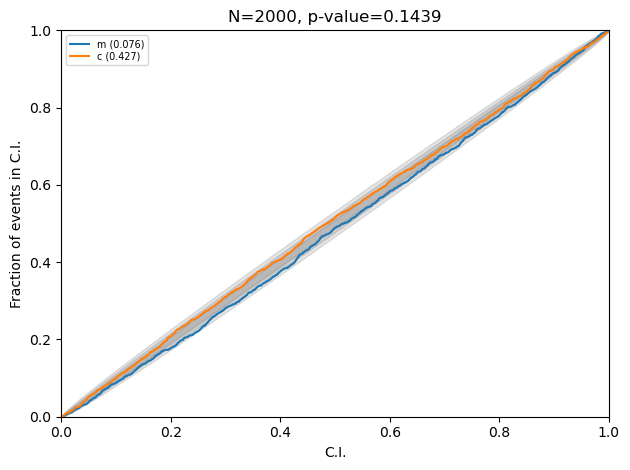

In [33]:
trainer.test(model)

# Example posteriors

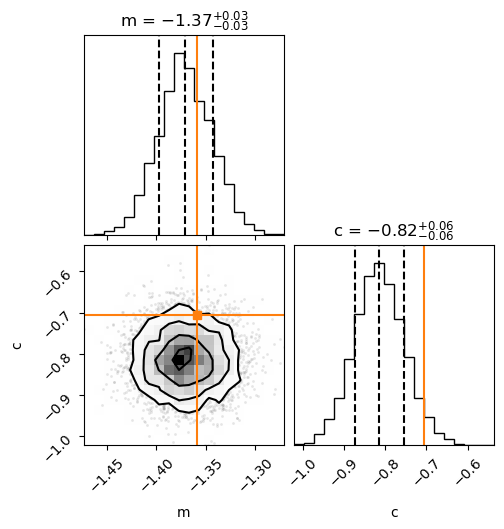

In [34]:
for idx, (theta_test, data_test) in enumerate(test_data):
    if idx == 5: break 
    with torch.no_grad():
        samples = model.flow.condition(data_test).sample([5000])
    live_plot_samples(samples, theta_test)
    plt.show()